In [6]:
import numpy as np
import pandas as pd

import matplotlib.animation as animation
from scipy.integrate import odeint
from numpy import arange
from pylab import *
%matplotlib inline

In [147]:
class Simulation():
    def __init__(self, n_queue, n_services, intensity_arrival, intensity_depart):
        self.n_queue = n_queue
        self.n_services = n_services
        
        self.num_in_services = 0
        self.num_in_queue = 0
        
        self.intensity_arrival = intensity_arrival
        self.intensity_depart = intensity_depart
        
        self.time = 0.0
        self.t_departs = set([float('inf')])
        self.t_depart = float('inf')
        self.t_arrival = self.generate_interarrival()
        
        self.num_arrivals = 0
        self.num_departs = 0
        self.num_cancels = 0
        
    def advance_time(self):
        self.t_depart = min(self.t_departs)
        
        t_event = min(self.t_arrival, self.t_depart)
        self.time = t_event
        
        if self.t_arrival < self.t_depart:
            self.handle_arrival_event()
        else:
            self.handle_depart_event()
            
    def handle_arrival_event(self):
        self.num_arrivals += 1
        
        if self.num_in_services < self.n_services:
            self.num_in_services += 1
            self.t_departs.add(self.time + self.generate_service())
        elif self.num_in_queue < self.n_queue:
            self.num_in_queue += 1
        else:
            self.num_cancels += 1
            
        self.t_arrival = self.time + self.generate_interarrival()
        
    def handle_depart_event(self):
        self.num_in_services -= 1
        self.num_departs += 1
        self.t_departs.remove(self.t_depart)
        
        if self.num_in_queue > 0:
            self.num_in_queue -= 1
            self.num_in_services += 1
            self.t_departs.add(self.time + self.generate_service())
        else:
            self.t_depart = float('inf')
    
    def generate_interarrival(self):
        return np.random.exponential(self.intensity_arrival)
    
    def generate_service(self):
        return np.random.exponential(self.intensity_depart)    

In [148]:
def smo(state, t):
    new_state = np.zeros(len(state))
    new_state[0] = -l * state[0] + nu * state[1]
    new_state[1] = l * state[0] - (l + nu) * state[1] + 2 * nu * state[2]
    new_state[2] = l * state[1] - (l + 2 * nu) * state[2] + 3 * nu * state[3]
    new_state[3] = l * state[2] - (l + 3 * nu) * state[3] + 3 * nu * state[4]
    
    new_state[4] = l * state[3] - (l + 3 * nu) * state[4] + 3 * nu * state[5]
    new_state[5] = l * state[4] - (l + 3 * nu) * state[5] + 3 * nu * state[6]
    new_state[6] = l * state[5] - 3 * nu * state[6]
    
    return new_state   

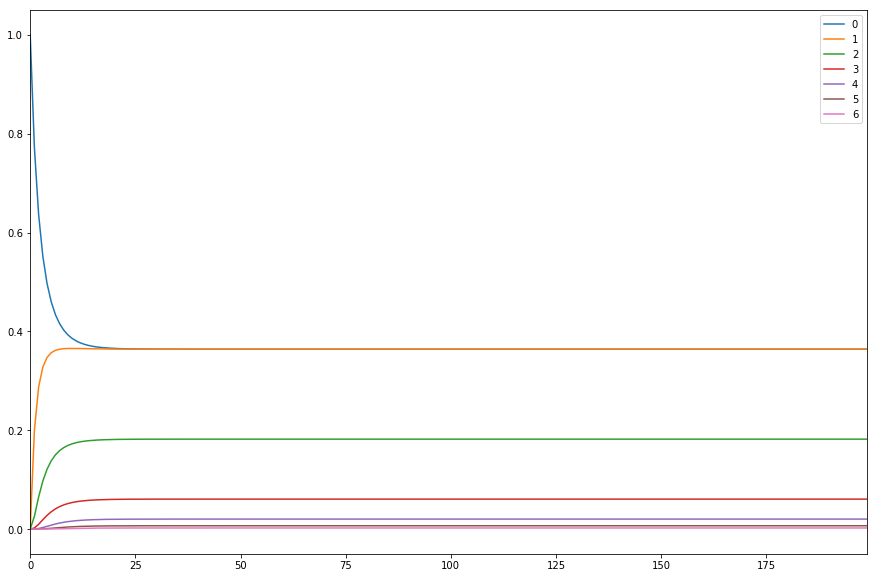

In [149]:
l = 3
nu = 3

t = np.arange(0, 20, 0.1)
init_state = [1, 0, 0, 0, 0, 0, 0]

state = odeint(smo, init_state, t)
state = pd.DataFrame(state)

state.plot(figsize = (15, 10))

In [152]:
np.random.seed(0)
n_services = 3
n_queue = 3
num_events = 10000

s = Simulation(n_services=n_services, 
               n_queue=n_queue, 
               intensity_arrival=l,
               intensity_depart=nu)

In [153]:
n = n_services + n_queue + 1
state_tmp = dict(zip(np.arange(n), np.zeros(n)))
state_s = pd.DataFrame(columns=['time', 0, 1, 2, 3, 4, 5, 6])

prev_time = 0
prev_state = 0
for i in range(num_events):
    s.advance_time()
    
    delta_time = s.time - prev_time
    state_tmp[prev_state] += delta_time
    state_tmp['time'] = s.time
    state_s = state_s.append(state_tmp, ignore_index=True)
    
    prev_time = s.time
    prev_state = s.num_in_services + s.num_in_queue

for i in range(0, 7):
    state_s.loc[:, i] = state_s[i] / state_s['time']

C:\Users\TEMP.danil\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: '>' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects


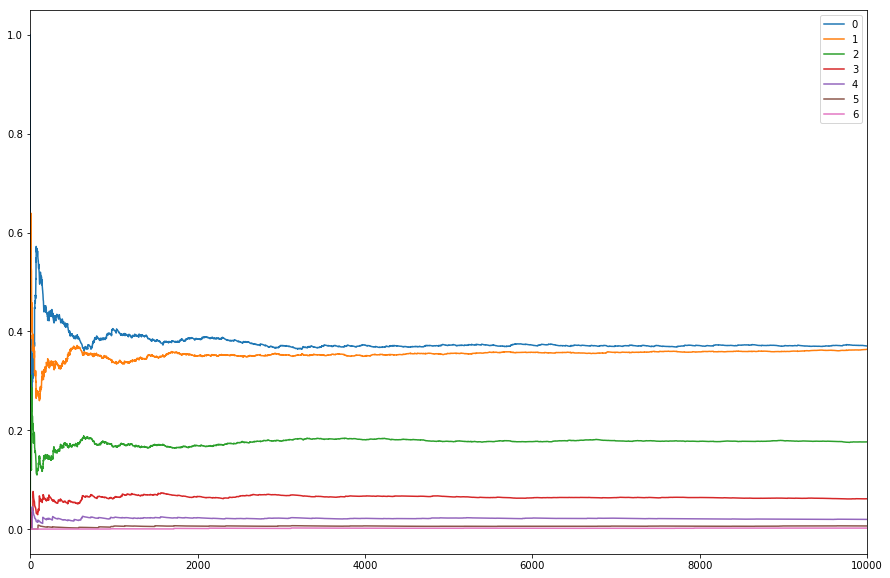

In [155]:
state_s[[0, 1, 2, 3, 4, 5, 6]].plot(figsize = (15, 10))